In [60]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics.cluster import adjusted_rand_score
from hausdorff import hausdorff_distance

from Bio.Cluster import kmedoids

from itertools import combinations

import pickle

In [2]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arr_x = np.array(df['x'][i:i+POINTS_NUM_PER_TR])
        arr_y = np.array(df['y'][i:i+POINTS_NUM_PER_TR])
        arr = np.append(arr_x,arr_y)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=POINTS_NUM_PER_TR
    return data

In [3]:
def discretization(data):
    
    # 网格坐标化
    data = np.round(data)
    tr_point = [    [  (data[j][i],data[j][i+POINTS_NUM_PER_TR])    for i in range(POINTS_NUM_PER_TR)]     
                           for j in range(len(data))]
    
    
    # 去掉连续落在同一区间上的点
    for i in range(len(tr_point)):
        tmp = []
        l = tr_point[i].copy()
        for j in range(POINTS_NUM_PER_TR-1):
            if l[j] == l[j+1]:
                tmp.append(j)
        tr_point[i] = [l[i] for i in range(POINTS_NUM_PER_TR) if i not in tmp]
        
    # 防止出现跨越的点
    for i in range(len(tr_point)):
        tmp = tr_point[i].copy()  # [(),(),...,()]
        count = 0 # 添加的点造成的偏移
        for j in range(len(tmp) - 1):
            now_p = tmp[j]
            next_p = tmp[j + 1]
            if not(tr_point[i][j + count] == now_p and tr_point[i][j + count + 1] == next_p):
                print('WRONGGGGG: ',now_p,next_p,tr_point[i][j + count],tr_point[i][j + count],)
                break
            if now_p[0] == next_p[0] and abs(now_p[1] - next_p[1]) == 1:
                continue
            elif abs(now_p[0] - next_p[0]) == 1 and now_p[1] == next_p[1]:
                continue   
            else:
                # print(now_p,next_p)
                delta_x = int(abs(now_p[0] - next_p[0]))
                delta_y = int(abs(now_p[1] - next_p[1]))
                if delta_x == 0:
                    step = (next_p[1] - now_p[1]) / delta_y
                    for k in range(1,delta_y,1):
                        tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                    count = count + delta_y - 1
                    continue
                elif delta_y == 0:
                    step = (next_p[0] - now_p[0])/delta_x
                    for k in range(1,delta_x,1):
                        tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                    count = count + delta_x - 1
                    continue
                else:
                    step_x = (next_p[0] - now_p[0])/delta_x
                    step_y = (next_p[1] - now_p[1]) / delta_y
                    k = 1
                    while delta_x != 0 and delta_y != 0:
                        tr_point[i].insert(j + count + 1,(now_p[0] + k * step_x,now_p[1]))
                        tr_point[i].insert(j + count + 2,(now_p[0] + k * step_x,now_p[1] + k * step_y))
                        count = count + 2
                        k = k + 1
                        delta_x = delta_x - 1
                        delta_y = delta_y - 1
                    if delta_x == 0 and delta_y == 0:
                        tr_point[i].pop(j + count)
                        count = count - 1
                    elif delta_x == 0:
                        step = (next_p[1] - now_p[1]) / delta_y
                        for k in range(1,delta_y,1):
                            tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                        count = count + delta_y - 1
                        continue
                    elif delta_y == 0:
                        step = (next_p[0] - now_p[0])/delta_x
                        for k in range(1,delta_x,1):
                            tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                        count = count + delta_x - 1
                        continue
                        
    return tr_point

In [4]:
def distMatrix(data):
    length = len(data)
    mat = [[]]
    for i in range(1,length):
        tmp = []
        for j in range(i):
            tmp.append(dist(np.array(data[i]),np.array(data[j])))
        mat.append(tmp) 
    return mat

In [5]:
def dist(a,b):
    
    return hausdorff_distance(a,b)

In [7]:
def cost(data,labels):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(np.array(data[i]),np.array(data[labels[i]]))
    loss = loss / len(data)
    return loss

In [10]:
def chooseK(data,K,mat):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels = cluster(data,k,mat)
        y[k-3] = cost(data, labels)
    plt.plot(x,y)
    plt.show()

In [11]:
def RI(a,b):
    ss = 0
    dd = 0
    sum = 0
    for com in combinations(range(len(a)),2):
        sum = sum + 1
        if (a[com[0]] == a[com[1]]) and (b[com[0]] == b[com[1]]):
            ss = ss + 1
        if (a[com[0]] != a[com[1]]) and (b[com[0]] != b[com[1]]):
            dd = dd + 1
    return (ss + dd) / sum

In [52]:
def stableClustering(data,k,mat):
    labels = cluster(k,mat)  # [121,111,123,123,121,111,...]
    min_cost = cost(data,labels)
    for i in range(50): # 取50次聚类中损失函数最小的
        labels_ = cluster(k,mat)
        cost_ = cost(data,labels_)
        if cost_ < min_cost:
            labels = labels_
            min_cost = cost_
    print('min_cost:'+str(min_cost))
    return labels

In [35]:
#  clusterid 中的类号是指的是代表聚类中心的元素号。
def cluster(K,mat):
    clusterid, error, nfound = kmedoids(mat,K,npass = 100)
    return clusterid

In [48]:
def getLabelResult(originalData,data,centers):
    result = []
    for i in originalData:
        distArr = []
        for j in range(len(centers)):
            distArr.append(hausdorff_distance(np.array(i),np.array(data[centers[j]])))
        minDist = np.min(distArr)
        result.append(distArr.index(minDist))
    return result

In [37]:
def init():
    df = pd.read_csv('data/all.csv')
    num_tr = int(len(df)/POINTS_NUM_PER_TR)
    print('num_tr:'+str(num_tr))
    disc_data = discretization(df2array(df))
    mat = distMatrix(disc_data)
    return disc_data,mat

In [38]:
def checkStability1(k,n): # 测试对于同一数据集，不同聚类结果的稳定性
    ri = 0
    ari = 0
    N = n
    for i in range(N):
        l1 = stableClustering(DISC_DATA,k,MAT)
        l2 = stableClustering(DISC_DATA,k,MAT)
        ri = ri + RI(l1,l2)
        ari = ari + adjusted_rand_score(l1,l2)
        print(RI(l1,l2),adjusted_rand_score(l1,l2))
    return ri/N,ari/N

In [44]:
def checkStability2(k,n): # 测试对于同一数据集的聚类结果与通过比较距离的聚类结果的稳定性
    ri = 0
    ari = 0
    N = n
    for i in range(N):
        l1 = stableClustering(DISC_DATA,k,MAT)
        l2 = getLabelResult(DISC_DATA,DISC_DATA,list(set(l1)))
        ri = ri + RI(l1,l2)
        ari = ari + adjusted_rand_score(l1,l2)
        print(RI(l1,l2),adjusted_rand_score(l1,l2))
    return ri/N,ari/N    

In [18]:
DISC_DATA,MAT = init()

num_tr:532


In [69]:
checkStability1(4,3)

min_cost:6.799204172193893
min_cost:6.799204172193893
1.0 1.0
min_cost:6.799204172193893
min_cost:6.799204172193893
1.0 1.0
min_cost:6.799204172193893
min_cost:6.799204172193893
1.0 1.0


(1.0, 1.0)

In [70]:
checkStability2(4,3)

min_cost:6.799204172193893
1.0 1.0
min_cost:6.799204172193893
1.0 1.0
min_cost:6.799204172193893
1.0 1.0


(1.0, 1.0)

In [71]:
checkStability1(5,3)
checkStability2(5,3)
checkStability1(6,3)
checkStability2(6,3)

min_cost:6.215772510690886
min_cost:6.215772510690886
1.0 1.0
min_cost:6.215772510690886
min_cost:6.215772510690886
0.9985627911586877 0.9958859614656844
min_cost:6.215772510690886
min_cost:6.215772510690886
0.9964175976664826 0.9897417684451352
min_cost:6.215772510690886
0.9985627911586877 0.9958859614656844
min_cost:6.216948841802622
0.9954405788482505 0.9868675125458148
min_cost:6.215772510690886
1.0 1.0
min_cost:5.665232358911372
min_cost:5.672597258544
0.9344901802528921 0.7725861831607265
min_cost:5.665232358911372
min_cost:5.665232358911372
1.0 1.0
min_cost:5.665232358911372
min_cost:5.665232358911372
1.0 1.0
min_cost:5.665232358911372
1.0 1.0
min_cost:5.665232358911372
1.0 1.0
min_cost:5.665232358911372
1.0 1.0


(1.0, 1.0)

In [72]:
checkStability1(6,6)

min_cost:5.672597258544
min_cost:5.665232358911372
0.9344901802528921 0.7725861831607265
min_cost:5.665232358911372
min_cost:5.672597258544
0.9307520212961783 0.7599526571506109
min_cost:5.673897804626409
min_cost:5.665232358911372
0.9809693725840024 0.9343752098246935
min_cost:5.665232358911372
min_cost:5.665232358911372
1.0 1.0
min_cost:5.665232358911372
min_cost:5.672597258544
0.9335131614346601 0.7691651711343526
min_cost:5.665232358911372
min_cost:5.665232358911372
1.0 1.0


(0.9632874559279555, 0.8726798702117305)

In [63]:
def genBaseline():
    Ks = [3,4,5,6]
    for k in Ks:
        baseline = stableClustering(DISC_DATA,k,MAT).tolist()
        with open('./baseline'+str(k)+'.pickle','wb') as f:#dict转txt
            pickle.dump(baseline,f,pickle.HIGHEST_PROTOCOL)
        f.close()

In [64]:
genBaseline()

min_cost:7.65497643745643
min_cost:6.799204172193893
min_cost:6.215772510690886
min_cost:5.665232358911372


In [73]:
ORIGINAL = df2array(pd.read_csv('./data/all.csv'))

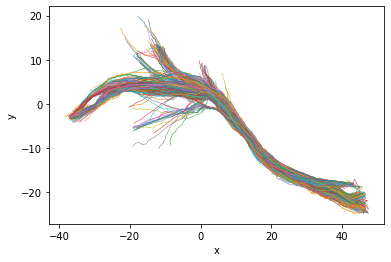

In [74]:
for i in range(len(ORIGINAL)):
    x = ORIGINAL[i][:500]
    y = ORIGINAL[i][500:]
    plt.plot(x,y,linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.show()

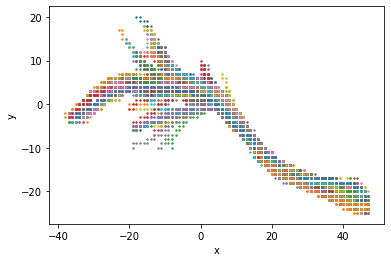

In [79]:
for i in range(len(DISC_DATA)):
    x = [p[0] for p in DISC_DATA[i]]
    y = [p[1] for p in DISC_DATA[i]]
    plt.scatter(x,y,2)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

### End